In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

import pprint as pp

In [47]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# The Data


>The Multi-Domain Sentiment Dataset contains product reviews taken from Amazon.com from many product types (domains). Some domains (books and dvds) have hundreds of thousands of reviews. Others (musical instruments) have only a few hundred. Reviews contain star ratings (1 to 5 stars) that can be converted into binary labels if needed. This page contains some descriptions about the data. If you have questions, please email Mark Dredze or John Blitzer. 

http://www.cs.jhu.edu/~mdredze/datasets/sentiment/

In [0]:
csv_file = '../content/gdrive/My Drive/NLP-data/books_reviews.csv'
df = pd.read_csv(csv_file)

In [0]:
df['rating'] = df['rating'].astype('category')

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973194 entries, 0 to 973193
Data columns (total 2 columns):
rating         973194 non-null category
review_text    973183 non-null object
dtypes: category(1), object(1)
memory usage: 8.4+ MB


In [51]:
df.head(10)

,rating,review_text
0,5.0,This all-Spanish handbook for parents with new...
1,5.0,McCarthy's writing and portrayal of Lester Bal...
2,2.0,Do you giggle uncontrollably when poking corps...
3,5.0,I was initiated into the world of Cormac McCar...
4,4.0,I cannot speak to the literary points in the n...
5,4.0,There is no denying the strain of Faulkner tha...
6,5.0,I have read sevral of McCarthy's other novels....
7,5.0,This is a gripping novel that probes the bread...
8,1.0,"If you're considering buying the Peter Smith ""..."
9,2.0,What I didn't realise when I ordered this is t...


In [52]:
sample = df[df['rating'] == 2].sample(1)
pp.pprint(sample['review_text'].values[0])
print('-'*100)
print('Number of words: %d' % sample['review_text'].str.split().apply(len))
print('Rating: %d stars' % sample['rating'].values[0])

('Simple is definitely the word to describe this book. The photography is '
 'gorgeous and the pictures take up most of the space.But the projects are '
 "contrived and poorly explained for beginners. A mix of retro hippie/today's "
 "young hip designs. There isn't one project that interests me nor is there "
 'any inspiration to be taken from these designs. I expect better books from '
 'Interweave Press. This one is a disappointment. I gave the same review for '
 'Color on Color by the same author')
----------------------------------------------------------------------------------------------------
Number of words: 82
Rating: 2 stars


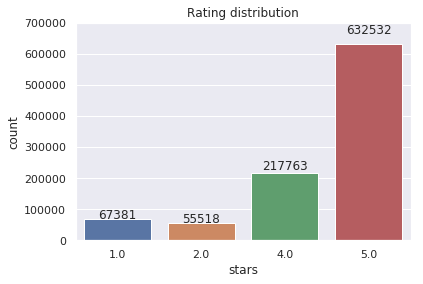

In [53]:
def plot_rating_dist(df, x='rating', title='Rating distribution', xlabel='stars', ylim=700000):
    ax = sns.countplot(x=x, data=df)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    for rect in ax.containers[0]:
        tw = rect.get_width() / 2.
        tx = rect.get_x() + tw
        height = rect.get_height()
        ty = 1.05 * height
        ax.text(tx, ty, height, ha='center')

    ax.set_ylim(0, ylim)
    
plot_rating_dist(df)

In [0]:
def binary_labels(df, min_set=None):
 
    # Cleanning data set
    count = df['review_text'].str.len()
    df = df[(count > 3) | (count < 4000)].copy()
    
    # Equilize dataset sample size
    if min_set is None:
        min_set = df['rating'].value_counts().min() * 4
    
    # Split rating 1.0, 2.0 as negative reviews
    rating_1 = df[df['rating'] == 1.0].iloc[:min_set // 4]
    rating_2 = df[df['rating'] == 2.0].iloc[:min_set // 4]
    negative_reviews = pd.concat([rating_1, rating_2])
    negative_reviews['label'] = 0
    
    # Split rating 4.0, 5.0 as positive reviews
    rating_4 = df[df['rating'] == 4.0].iloc[:min_set // 4]
    rating_5 = df[df['rating'] == 5.0].iloc[:min_set // 4]
    positive_reviews = pd.concat([rating_4, rating_5])
    positive_reviews['label'] = 1
    
    dataset = pd.concat([negative_reviews, positive_reviews])
    dataset.sort_index(inplace=True)
    
    return dataset

dataset = binary_labels(df,  min_set=50000)

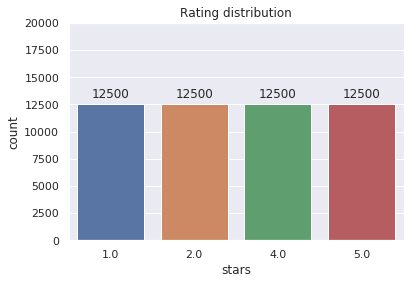

In [54]:
plot_rating_dist(dataset, ylim=20000)

texts size:  50000
labels size:  50000


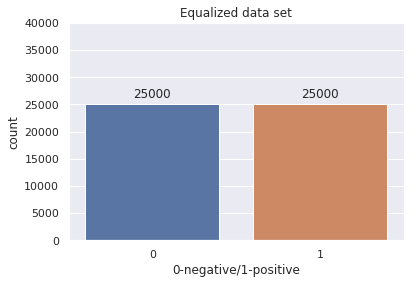

In [55]:
texts = dataset['review_text'].astype(str)
labels = dataset['label'].astype('int32')

print('texts size: ', texts.size)
print('labels size: ', labels.size)

plot_rating_dist(pd.concat([texts, labels], axis=1), x='label', title='Equalized data set', xlabel='0-negative/1-positive', ylim=40000)

# Preprocessing Text data

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
MAX_NUM_FEATURES = 20000
NGRAN_RANGE = 2
MAX_SEQUENCE_LENGTH = 400
VALIDATION_SPLIT = .1

In [58]:
from keras.preprocessing import text

tokenizer = text.Tokenizer(num_words=MAX_NUM_FEATURES)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 96740 unique tokens.


In [71]:
import numpy as np

print(len(sequences), 'sequences')
print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

50000 sequences
Average train sequence length: 168


In [0]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [73]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + MAX_NUM_FEATURES for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update MAX_NUM_FEATURES
    MAX_NUM_FEATURES = np.max(list(indice_token.keys())) + 1
    print('Update MAX_NUM_FEATURES %d' % MAX_NUM_FEATURES)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Update MAX_NUM_FEATURES 1248043
50000 sequences
Average train sequence length: 335


In [0]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [76]:
pp.pprint(data[0].tolist(), width=200, compact=True)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 32, 2483, 5241, 13, 689, 15, 104, 3224, 51, 1259, 1526, 13, 91, 1545, 30, 5, 3339, 882,
 2337,

In [0]:
# Split the date into train and validation sets
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

X_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
X_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [78]:
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape, 'type', y_train.dtype)
print('y_val shape:', y_val.shape, 'type', y_val.dtype)

X_train shape: (45000, 400)
X_val shape: (5000, 400)
y_train shape: (45000,) type int32
y_val shape: (5000,) type int32


# Fasttext Model

In [0]:
from keras.models import Sequential
from keras.layers import Embedding, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint

In [0]:
def fasttext_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_FEATURES,
                        output_dim=50,
                        input_length=MAX_SEQUENCE_LENGTH))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
# callback
checkpoint = ModelCheckpoint(filepath='../content/gdrive/My Drive/NLP-data/Fasttext_ng2_model_weights.{epoch:02d}-{val_acc:.2f}.hdf5',
                             monitor='val_acc', 
                             mode='max', 
                             verbose=1, 
                             save_best_only=True)

In [82]:
model = fasttext_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 400, 50)           62402150  
_________________________________________________________________
global_average_pooling1d_2 ( (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 62,402,201
Trainable params: 62,402,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [84]:
%%time

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint])

Train on 45000 samples, validate on 5000 samples
Epoch 1/20
45000/45000 [==============================] - 456s 10ms/step - loss: 0.6522 - acc: 0.6160 - val_loss: 0.6991 - val_acc: 0.4566

Epoch 00001: val_acc improved from -inf to 0.45660, saving model to ../content/gdrive/My Drive/NLP-data/Fasttext_ng2_model_weights.01-0.46.hdf5
Epoch 2/20
45000/45000 [==============================] - 457s 10ms/step - loss: 0.4767 - acc: 0.8422 - val_loss: 0.5413 - val_acc: 0.7052

Epoch 00002: val_acc improved from 0.45660 to 0.70520, saving model to ../content/gdrive/My Drive/NLP-data/Fasttext_ng2_model_weights.02-0.71.hdf5
Epoch 3/20
45000/45000 [==============================] - 453s 10ms/step - loss: 0.3176 - acc: 0.9202 - val_loss: 0.4253 - val_acc: 0.8080

Epoch 00003: val_acc improved from 0.70520 to 0.80800, saving model to ../content/gdrive/My Drive/NLP-data/Fasttext_ng2_model_weights.03-0.81.hdf5
Epoch 4/20
45000/45000 [==============================] - 451s 10ms/step - loss: 0.2237 - acc

In [0]:
def plot_results(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

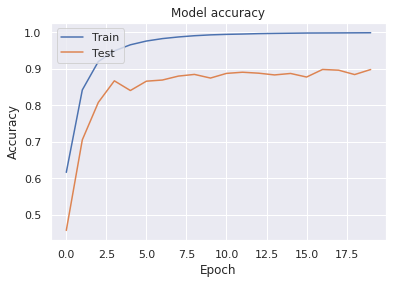

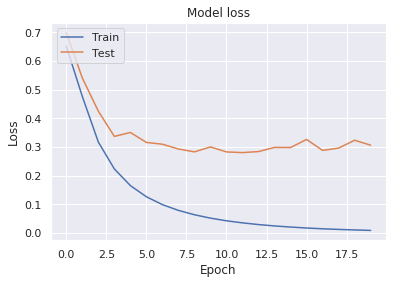

In [86]:
plot_results(history)

In [0]:
model.save(filepath='../content/gdrive/My Drive/NLP-data/Fasttext_ng2_model_weights_last_epoch.hdf5')